In [2]:
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt
plt.style.use('custom_standard')
plt.style.use('custom_small')
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools
import copy
from pathlib import Path
import lir_proteome_screen_pssm.data_loaders as dl

%load_ext autoreload
%autoreload 2

Create PSSMs (this code will eventually be moved to `processing_scripts/create_pssms.py`)

based on the residue frequency logos, I think I will focus on the 7-mers as there is not much extra information added from the 8-mers.

parameters:
- input sequence set
    - full binder set
    - highly enriched binder set
    - ilir set
- background
    - proteome frequencies
    - input library frequencies
    - ilir frequencies
    - nonbinder frequencies (undefined motif positions)
- readcount cutoff
    - 0
    - nonzero

Planned pssms:
- screening pssm 1
    - FG - all binders
    - BG - input library
- screening pssm 2
    - FG - all binders
    - BG - non-binders
- screening pssm 3
    - FG - all binders
    - BG - proteome
- screening pssm 4
    - FG - all binders - weighted by z-score
    - BG - non-binder
- screening pssm 5
    - FG - binders with z-score > 2.4
    - BG - proteome

- ilir pssm 1
    - FG - ilir binders (7-mers)
    - BG - ilir background
- ilir pssm 2
    - FG - ilir binders (7-mers)
    - BG - proteome
- ilir pssm 3
    - psi-blast pssm
        - FG - ilir binders (7-mers)
        - BG - proteome


I already have all of the backgrounds

In [3]:
dl.BGFREQS

background frequencies: 
 - proteome
 - input_library
 - ilir_bg
 - nonbinders_undef_pos

# screen binder sets

## binders - all

In [4]:
screen_df = pd.read_csv(env.RAWFILEPATHS.screening_hits_table)
binders_df = screen_df[screen_df['Bind/Nonbind'] == 'Bind'].copy()
nonbinders_df = screen_df[screen_df['Bind/Nonbind'] == 'Nonbind'].copy()

In [5]:
binders_df['avg_z_score'].describe()

count    297.000000
mean       2.356296
std        0.572327
min        1.700000
25%        1.880000
50%        2.180000
75%        2.700000
max        4.110000
Name: avg_z_score, dtype: float64

In [6]:
screen_binders_all = binders_df['first_7_residues'].tolist()
assert all([len(b) == 7 for b in screen_binders_all]), "All binders should be 7 residues long"

Text(0.5, 1.0, 'All Binders - old code')

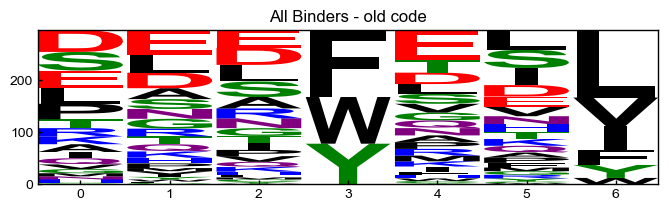

In [7]:
# double check that this produces the same results as my old code
fig, ax = plt.subplots(figsize=(8, 2))
mat_old = pssms.alignment_2_counts(screen_binders_all)
pssms.plot_logo(mat_old, ax=ax)
ax.set_title('All Binders - old code')

Text(0.5, 1.0, 'All Binders')

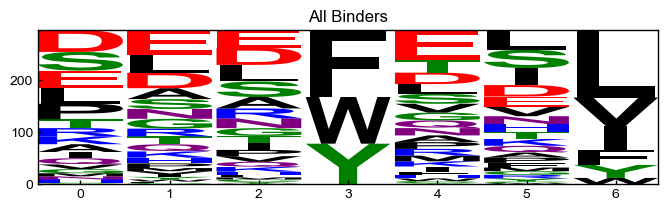

In [8]:
fig, ax = plt.subplots(figsize=(8, 2))
mat = pssms.seqlist_2_counts_matrix(screen_binders_all)
pssms.plot_logo(mat, ax=ax)
ax.set_title('All Binders')

In [9]:
assert (mat - mat_old).sum().sum() == 0  # should be 0

In [10]:
sb_all = pssms.seqlist_2_counts_matrix(screen_binders_all)
pssms.normalize_positions(sb_all).sum(axis=1)

pos
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
dtype: float64

## binders - all - weighted by z-score

Text(0.5, 1.0, 'All Binders - weighted')

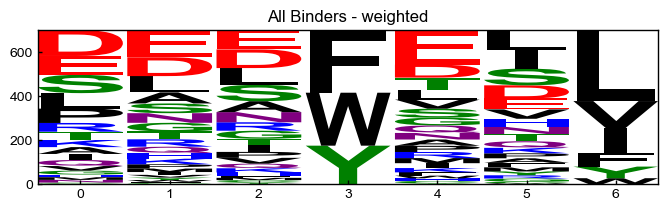

In [11]:
fig, ax = plt.subplots(figsize=(8, 2))
sb_all_weighted = pssms.seqlist_2_counts_matrix(binders_df['first_7_residues'].tolist(), weights=binders_df['avg_z_score'].tolist())
pssms.plot_logo(sb_all_weighted, ax = ax)
ax.set_title('All Binders - weighted')

## binders - z-score > 2.4

In [12]:
# fig, ax = plt.subplots(figsize=(8, 2))
# temp = binders_df[binders_df['avg_z_score'] > 2.4].copy()
# print(len(temp))
# mat = pssms.seqlist_2_counts_matrix(temp['first_7_residues'].tolist(), weights=temp['avg_z_score'].tolist())
# pssms.plot_logo(mat, ax = ax)
# ax.set_title('Weighted Logo of Binders')

117


Text(0.5, 1.0, 'Binders with z-score > 2.4')

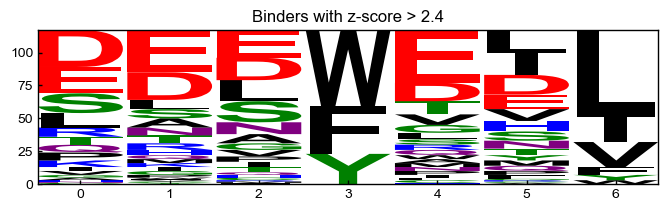

In [13]:
fig, ax = plt.subplots(figsize=(8, 2))
temp = binders_df[binders_df['avg_z_score'] > 2.4].copy()
print(len(temp))
sb_2_4 = pssms.seqlist_2_counts_matrix(temp['first_7_residues'].tolist())
pssms.plot_logo(sb_2_4, ax = ax)
ax.set_title('Binders with z-score > 2.4')

102


Text(0.5, 1.0, 'Binders with z-score > 2.5')

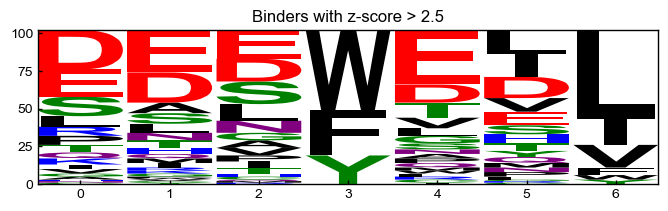

In [14]:
fig, ax = plt.subplots(figsize=(8, 2))
temp = binders_df[binders_df['avg_z_score'] > 2.5].copy()
print(len(temp))
sb_2_5 = pssms.seqlist_2_counts_matrix(temp['first_7_residues'].tolist())
pssms.plot_logo(sb_2_5, ax = ax)
ax.set_title('Binders with z-score > 2.5')

# ilir

In [15]:
ilir_df = pd.read_csv(env.RAWFILEPATHS.ilir_table)
# ilir_df['full_length_seq'] = ilir_df['UNIPROT ACC'].apply(lambda x: seqtools.download_uniprot_sequence(x))
ilir_df[['header', 'full_length_seq']] = ilir_df['UNIPROT ACC'].apply(lambda x: seqtools.download_uniprot_sequence(x)).apply(pd.Series)

In [16]:
def ids_equal(s: pd.Series):
    original_id = s['UNIPROT ACC']
    split_id = s['header'].split('|')[1]
    return original_id == split_id

ilir_df['ids_equal'] = ilir_df.apply(ids_equal, axis=1)
ilir_df['ids_equal'].value_counts()
assert ilir_df['ids_equal'].all(), "IDs should be equal"

In [17]:
def find_motif_in_sequence(s: pd.Series):
    """
    Find the motif in the sequence
    :param s: Series with 'full_length_seq' and 'first_7_residues'
    :return: start and end of the motif
    """
    seq = s['full_length_seq']
    motif = s['Sequence']
    matches = list(seqtools.find_all(seq, motif))
    if len(matches) == 0:
        return None
    elif len(matches) == 1:
        return matches
    else:
        print(f"Multiple matches found for {s['UNIPROT ACC']}: {matches}")
        return matches


ilir_df['start_position'] = ilir_df.apply(find_motif_in_sequence, axis=1)
ilir_df['n_matches'] = ilir_df['start_position'].apply(lambda x: len(x) if isinstance(x, list) else 0)
assert (ilir_df['n_matches']==1).all(), "All sequences should have exactly one match"
ilir_df['start_position'] = ilir_df['start_position'].apply(lambda x: x[0])

In [18]:
def get_7mer_from_full_length(s: pd.Series):
    """
    Get the 7-mer from the full length sequence
    :param s: Series with 'full_length_seq' and 'start_position'
    :return: 7-mer
    """
    seq = s['full_length_seq']
    start = s['start_position']
    return seq[start-1:start+6]  # want the n terminal residues so it's n-1 to n+6


ilir_df['7mer'] = ilir_df.apply(get_7mer_from_full_length, axis=1)
assert (ilir_df['7mer'].str[1:] == ilir_df['Sequence']).all(), "7mer[1:] and Sequence don't match"

Text(0.5, 1.0, 'ILIR Binders')

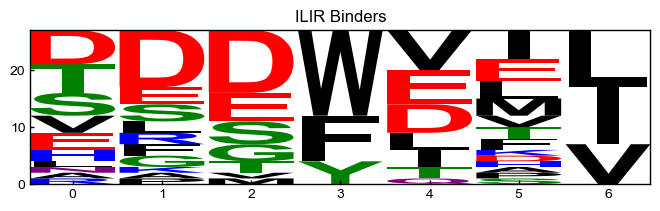

In [19]:
ilir_binders = pssms.seqlist_2_counts_matrix(ilir_df['7mer'].to_list())
fig, ax = plt.subplots(figsize=(8, 2))
pssms.plot_logo(ilir_binders, ax=ax)
ax.set_title('ILIR Binders')

# constructing pssms

In [20]:
def make_pssm(df_counts, bg=None, min_count=0, pseudocount=0.0, plot=True, plot_title=None, ax=None):
    fg = df_counts.copy()
    fg = fg + pseudocount
    fg = pssms.mask_low_counts(fg, min_count=min_count)
    fg = pssms.normalize_positions(fg)
    pssm = pssms.freq_2_weight_matrix(fg, bg=bg)
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 2))
        pssms.plot_logo(pssm, ax=ax)
        ax.set_title(plot_title)
    return pssm

In [21]:
temp = ilir_binders.copy()
temp=pssms.normalize_positions(temp)
temp.sum(axis=1).apply(lambda x: np.isclose(x, 1))

pos
0    True
1    True
2    True
3    True
4    True
5    True
6    True
dtype: bool

<Axes: xlabel='position'>

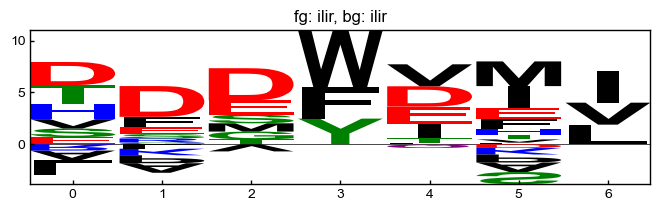

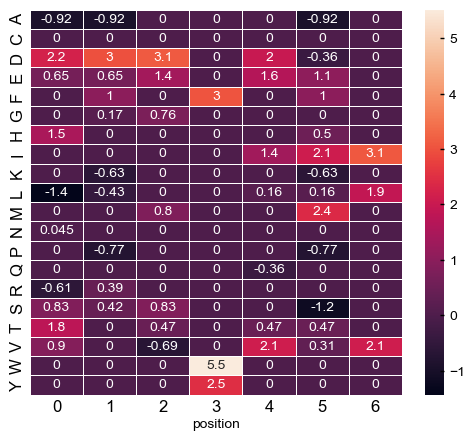

In [22]:
pssms.plot_logo_as_heatmap(
    make_pssm(ilir_binders, bg=dl.BGFREQS.ilir_bg, min_count=0, plot_title='fg: ilir, bg: ilir'),
)

<Axes: >

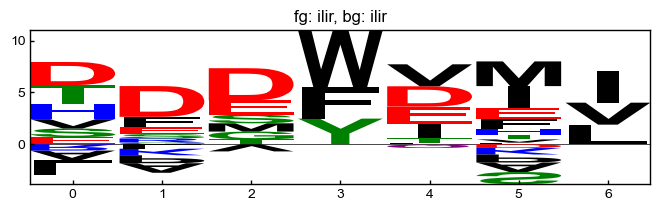

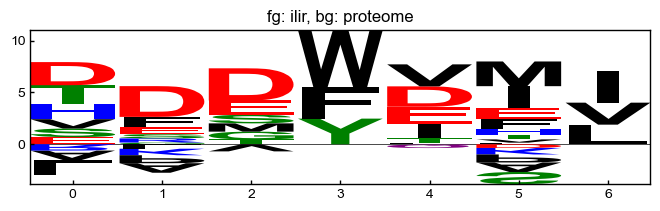

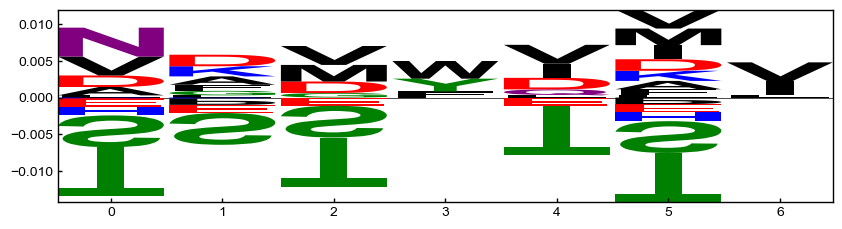

In [23]:
fg_ilir_bg_ilir = make_pssm(ilir_binders, bg=dl.BGFREQS.ilir_bg, min_count=0, plot_title='fg: ilir, bg: ilir');
fg_ilir_bg_proteome = make_pssm(ilir_binders, bg=dl.BGFREQS.proteome, min_count=0, plot_title='fg: ilir, bg: proteome');
pssms.plot_logo(fg_ilir_bg_proteome - fg_ilir_bg_ilir)

Differences between these backgrounds are probably super negligible

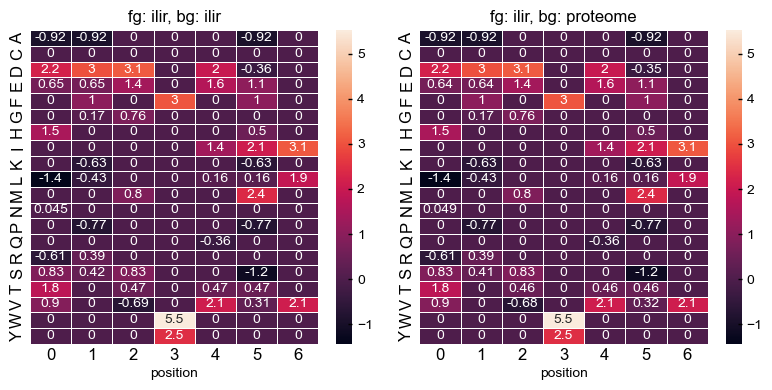

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
pssms.plot_logo_as_heatmap(
    fg_ilir_bg_ilir, ax=axes[0],
)
axes[0].set_title('fg: ilir, bg: ilir')
pssms.plot_logo_as_heatmap(
    fg_ilir_bg_proteome, ax=axes[1],
)
axes[1].set_title('fg: ilir, bg: proteome')
fig.tight_layout()
# pssms.plot_logo_as_heatmap(
#     fg_ilir_bg_proteome - fg_ilir_bg_ilir
# )

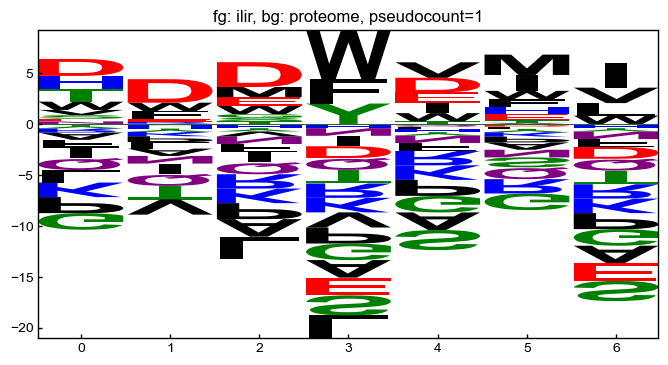

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
fg_ilir_bg_proteome = make_pssm(ilir_binders, bg=dl.BGFREQS.proteome, min_count=0, plot_title='fg: ilir, bg: proteome, pseudocount=1', pseudocount=1, ax=ax);

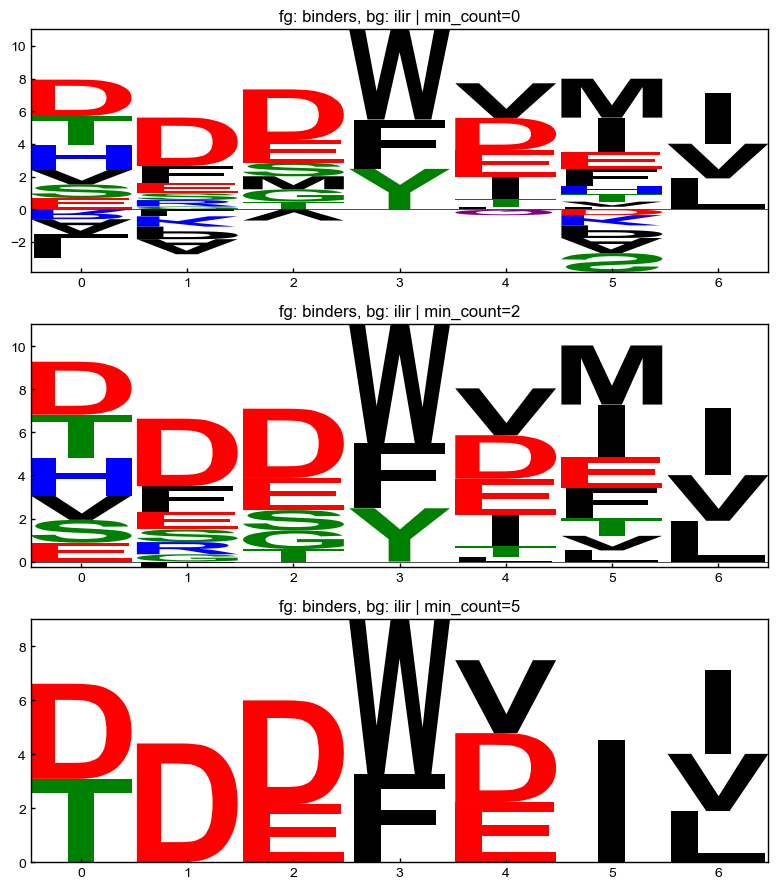

In [26]:
min_counts = [0, 2, 5]
fig, axes = plt.subplots(nrows=len(min_counts), ncols=1, figsize=(8, 3*len(min_counts)))
for ax, min_count in zip(axes, min_counts):
    make_pssm(
        ilir_binders,
        bg=dl.BGFREQS.ilir_bg,
        min_count=min_count,
        plot_title=f"fg: binders, bg: ilir | min_count={min_count}",
        ax=ax,
    )
fig.tight_layout()

<Axes: >

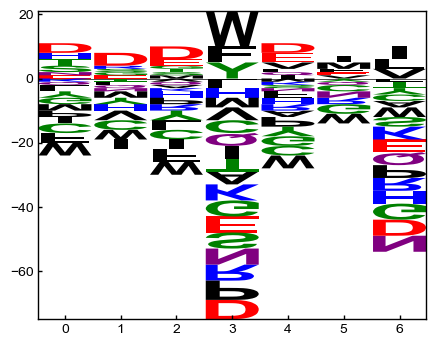

In [27]:
temp = pd.read_csv(env.DATA_DIR / 'processed' / 'pssms' / 'fg-ilir_bg-proteome_psiblast.csv')
temp.columns = [i.strip() for i in temp.columns]
fig, ax = plt.subplots(figsize=(5, 4))
pssms.plot_logo(temp, ax=ax)

<Axes: xlabel='position'>

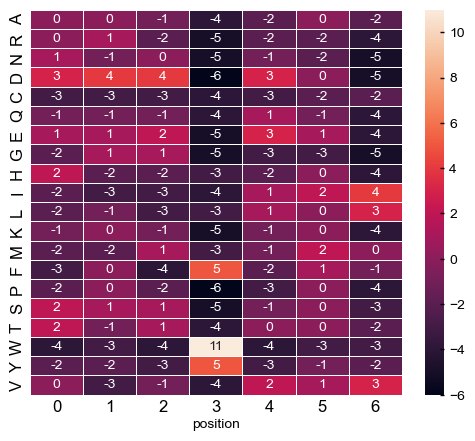

In [28]:
pssms.plot_logo_as_heatmap(temp)

`sb_all` = all binders <br> 
`sb_all_weighted` = all binders weighted by z-score <br>
`sb_2_4` = all binders with z-score > 2.4 <br>
`ilir_binders` = ilir binders <br>

In [29]:
Planned pssms:
- screening pssm 1
    - FG - all binders
    - BG - input library
- screening pssm 2
    - FG - all binders
    - BG - non-binders
- screening pssm 3
    - FG - all binders
    - BG - proteome
- screening pssm 4
    - FG - all binders - weighted by z-score
    - BG - non-binder
- screening pssm 5
    - FG - binders with z-score > 2.4
    - BG - proteome

- ilir pssm 1
    - FG - ilir binders (7-mers)
    - BG - ilir background
- ilir pssm 2
    - FG - ilir binders (7-mers)
    - BG - proteome
- ilir pssm 3
    - psi-blast pssm
        - FG - ilir binders (7-mers)
        - BG - proteome

SyntaxError: invalid syntax (2058106107.py, line 1)

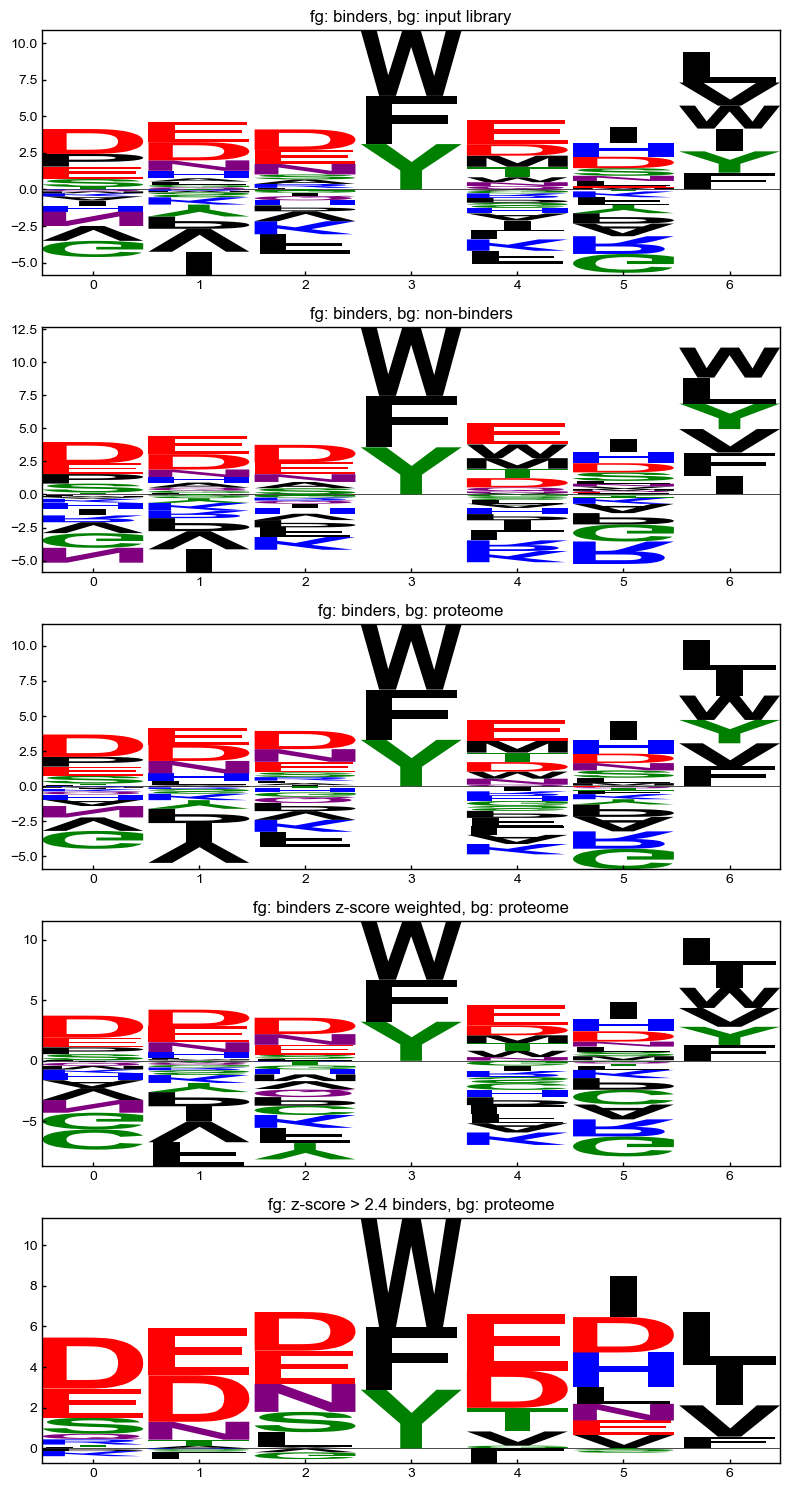

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 15))   

make_pssm(
    sb_all,
    bg=dl.BGFREQS.input_library,
    min_count=5,
    plot_title="fg: binders, bg: input library",
    ax=axes[0],
)
make_pssm(
    sb_all,
    bg=dl.BGFREQS.nonbinders_undef_pos,
    min_count=5,
    plot_title="fg: binders, bg: non-binders",
    ax=axes[1],
)
make_pssm(
    sb_all, 
    bg=dl.BGFREQS.proteome, 
    min_count=5, 
    plot_title="fg: binders, bg: proteome", 
    ax=axes[2],
)
make_pssm(
    sb_all_weighted,
    bg=dl.BGFREQS.proteome,
    min_count=5,
    plot_title="fg: binders z-score weighted, bg: proteome",
    ax=axes[3],
)
make_pssm(
    sb_2_4,
    bg=dl.BGFREQS.proteome,
    min_count=5,
    plot_title="fg: z-score > 2.4 binders, bg: proteome",
    ax=axes[4],
)
fig.tight_layout()

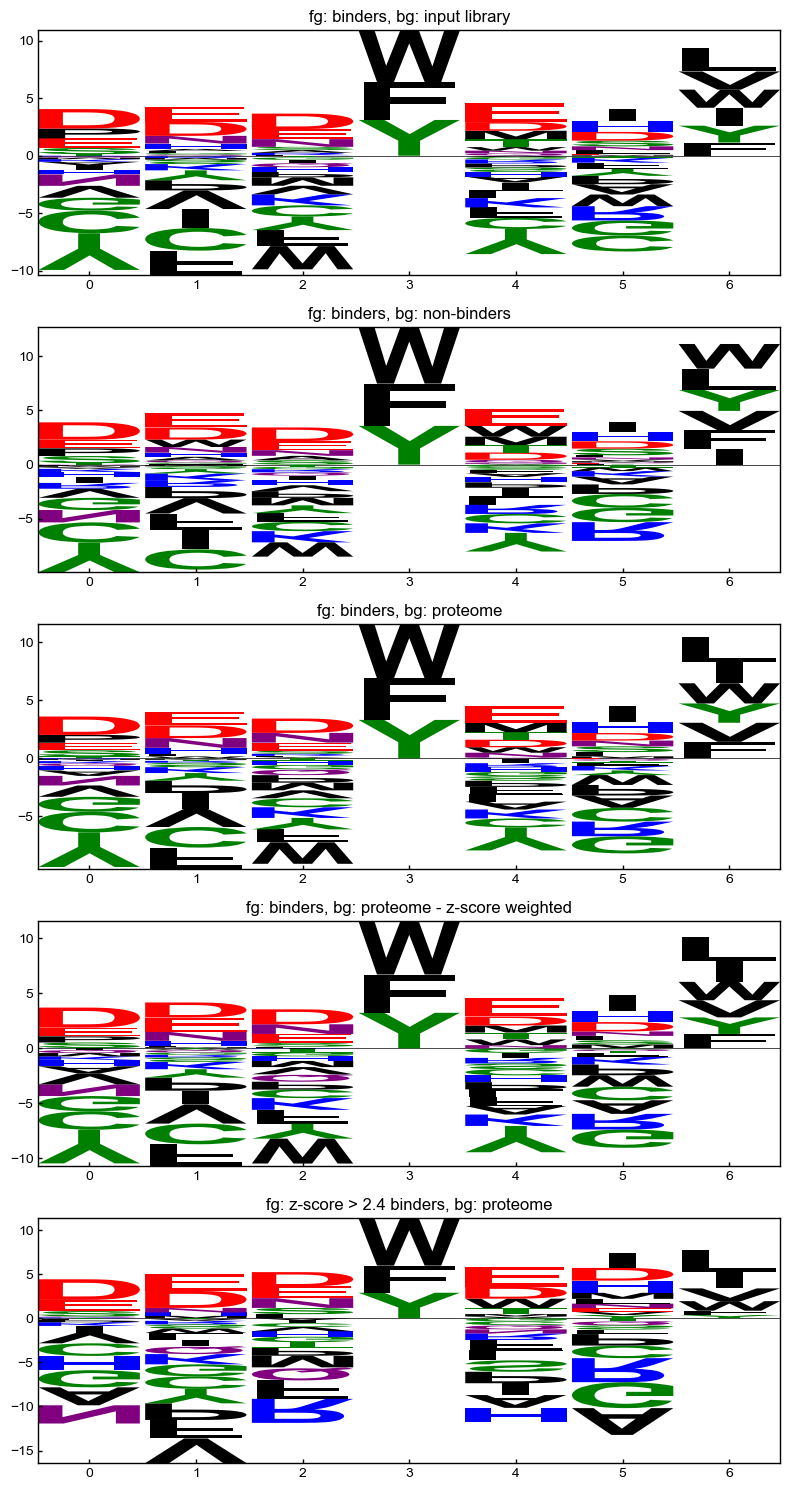

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 15))   

make_pssm(
    sb_all,
    bg=dl.BGFREQS.input_library,
    min_count=0,
    plot_title="fg: binders, bg: input library",
    ax=axes[0],
)
make_pssm(
    sb_all,
    bg=dl.BGFREQS.nonbinders_undef_pos,
    min_count=0,
    plot_title="fg: binders, bg: non-binders",
    ax=axes[1],
)
make_pssm(
    sb_all, 
    bg=dl.BGFREQS.proteome, 
    min_count=0, 
    plot_title="fg: binders, bg: proteome", 
    ax=axes[2],
)
make_pssm(
    sb_all_weighted,
    bg=dl.BGFREQS.proteome,
    min_count=0,
    plot_title="fg: binders, bg: proteome - z-score weighted",
    ax=axes[3],
)
make_pssm(
    sb_2_4,
    bg=dl.BGFREQS.proteome,
    min_count=0,
    plot_title="fg: z-score > 2.4 binders, bg: proteome",
    ax=axes[4],
)
fig.tight_layout()

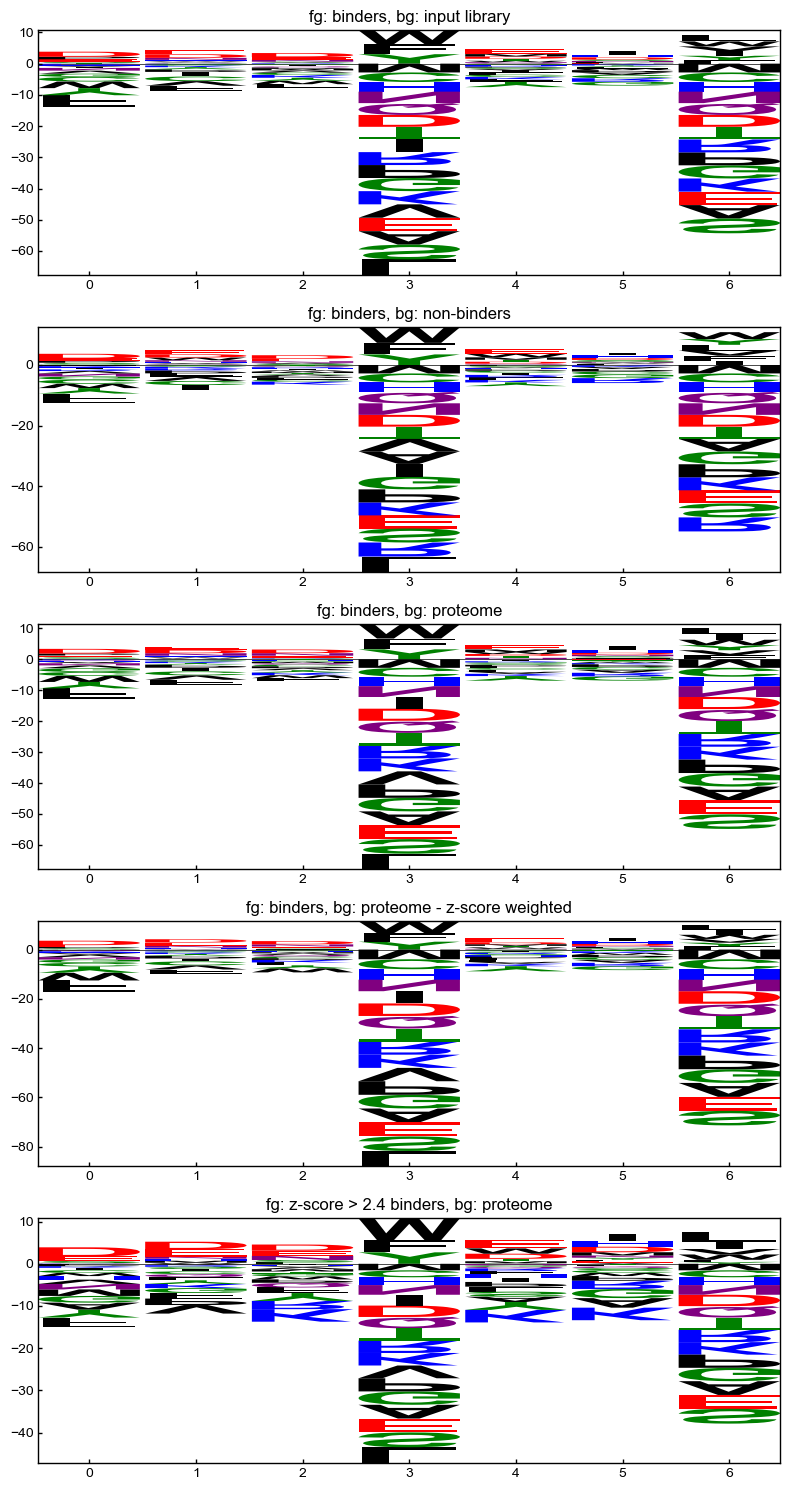

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 15))   

make_pssm(
    sb_all,
    bg=dl.BGFREQS.input_library,
    min_count=0,
    pseudocount=1,
    plot_title="fg: binders, bg: input library",
    ax=axes[0],
)
make_pssm(
    sb_all,
    bg=dl.BGFREQS.nonbinders_undef_pos,
    min_count=0,
    pseudocount=1,
    plot_title="fg: binders, bg: non-binders",
    ax=axes[1],
)
make_pssm(
    sb_all, 
    bg=dl.BGFREQS.proteome, 
    min_count=0, 
    pseudocount=1,
    plot_title="fg: binders, bg: proteome", 
    ax=axes[2],
)
make_pssm(
    sb_all_weighted,
    bg=dl.BGFREQS.proteome,
    min_count=0,
    pseudocount=1,
    plot_title="fg: binders, bg: proteome - z-score weighted",
    ax=axes[3],
)
x = make_pssm(
    sb_2_4,
    bg=dl.BGFREQS.proteome,
    min_count=0,
    pseudocount=1,
    plot_title="fg: z-score > 2.4 binders, bg: proteome",
    ax=axes[4],
)
fig.tight_layout()

<Axes: xlabel='position'>

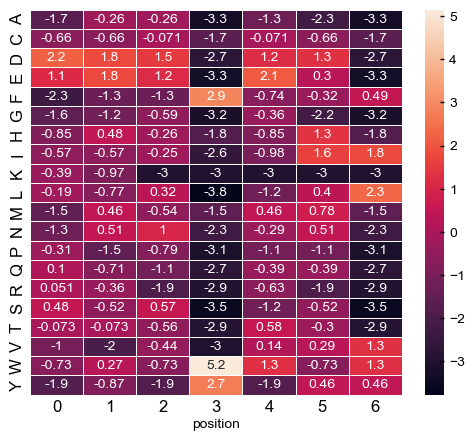

In [ ]:
pssms.plot_logo_as_heatmap(x)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0.013589,-2.401448,1.439854,1.101052,-3.986411,-0.816486,-1.179056,-0.285971,0.013589,1.013589,-1.179056,-1.179056,0.967785,-0.285971,0.101052,1.223042,0.183514,-0.664483,-3.986411,-2.986411
1,0.473021,-2.401448,0.967785,1.598552,-1.986411,0.335517,-0.401448,-1.401448,-0.285971,1.183514,-1.179056,0.335517,-0.664483,-0.079520,0.013589,0.335517,0.013589,-1.179056,-1.664483,-1.401448
2,0.537151,-1.664483,1.101052,1.142872,-1.401448,0.013589,-1.179056,-0.179056,-0.664483,1.057983,-1.664483,0.335517,-0.285971,-0.526979,0.335517,0.967785,-0.079520,-0.401448,-2.986411,-1.664483
3,-3.986411,-3.986411,-3.986411,-3.986411,3.035957,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,2.521384,2.317370
4,-0.179056,-1.664483,0.537151,1.871570,-0.986411,0.013589,-1.179056,-0.526979,-0.526979,0.335517,-0.401448,-0.079520,-0.179056,0.013589,-0.179056,0.335517,0.714029,0.183514,-1.401448,-2.401448
5,-0.526979,-1.986411,0.537151,0.405906,-0.664483,-0.986411,0.013589,1.101052,-0.179056,1.298991,-0.986411,0.013589,-0.526979,-0.179056,-0.986411,1.183514,-0.079520,0.261517,-2.401448,-1.179056
6,-3.986411,-3.986411,-3.986411,-3.986411,0.920480,-3.986411,-3.986411,1.568178,-3.986411,3.047012,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,-3.986411,1.820944,-0.285971,0.714029


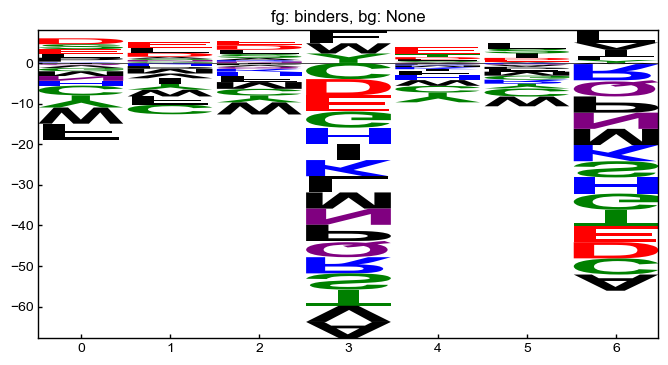

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
make_pssm(
    sb_all,
    bg=None,
    min_count=0,
    pseudocount=1,
    plot_title="fg: binders, bg: None",
    ax=ax,
)

There are a bunch of variables to test, so I will save the counts matrices to files and then generate pssms dynamically until I find the best performing ones. Then I will save those to the final files in the data directory.

# psi-blast pssms

<Axes: >

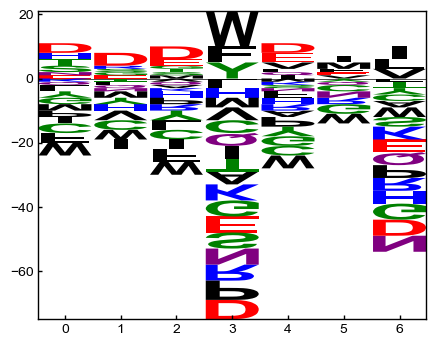

In [ ]:
temp = pd.read_csv(env.DATA_DIR / 'processed' / 'pssms' / 'fg-ilir_bg-proteome_psiblast.csv')
temp.columns = [i.strip() for i in temp.columns]
fig, ax = plt.subplots(figsize=(5, 4))
pssms.plot_logo(temp, ax=ax)

<Axes: >

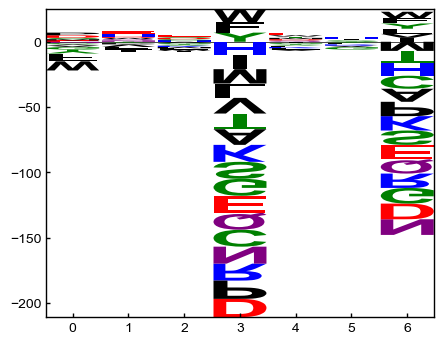

In [ ]:
temp = pd.read_csv(env.DATA_DIR / 'processed' / 'pssms' / 'screen-all_binders_psiblast_pssm.csv')
temp.columns = [i.strip() for i in temp.columns]
fig, ax = plt.subplots(figsize=(5, 4))
pssms.plot_logo(temp, ax=ax)

<Axes: >

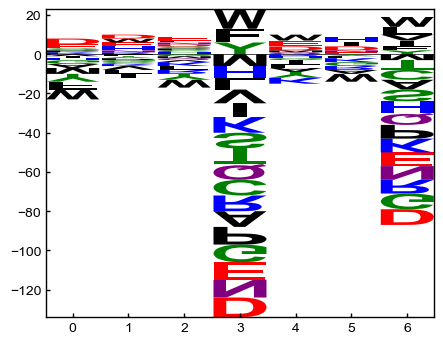

In [ ]:
temp = pd.read_csv(env.DATA_DIR / 'processed' / 'pssms' / 'screen-z_score_above_2_4_psiblast_pssm.csv')
temp.columns = [i.strip() for i in temp.columns]
fig, ax = plt.subplots(figsize=(5, 4))
pssms.plot_logo(temp, ax=ax)